<a href="https://colab.research.google.com/github/lesaum/cse5835final/blob/main/final_project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  A predictive model for the upper-airway microbiota and loss of asthma control among children


#Preparing the environment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import feature_selection
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from google.colab import drive, files
from sklearn.tree import DecisionTreeClassifier, plot_tree #for visualizing tree 
from sklearn.metrics import classification_report, confusion_matrix, f1_score, RocCurveDisplay #for checking testing results 
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC # Import the support vector classifier from sklearn
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

from google.colab import auth
auth.authenticate_user()
import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)
seed=200

#Prepare the data

Loading and encoding the data

In [2]:
RD_sheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/12_KDQkiBy0ZDB56MZgxFzum1JENBfEEILNcGF9qf02E/edit') 

# RD = RD_sheet.worksheet("Q2_RD_data_analysis_original") #original, commented out to use second sheet

RD = RD_sheet.worksheet("Q2_RD_data_analysis_select") #dataframe with selected features
RD = pd.DataFrame(RD.get_all_records())
print(RD['dt_YZ'].value_counts()) #yz01 makes up 55% of the data. Pretty balanced. 
LE = LabelEncoder()
dt_YZ_og = RD['dt_YZ']
RD['dt_YZ'] = LE.fit_transform(RD['dt_YZ'])
RD['virus'] = LE.fit_transform(RD['virus'])

#Uncomment if looking at the original dataset
# RD['site'] = LE.fit_transform(RD['site'])
# RD['Meteorological.Seasons'] = LE.fit_transform(RD['Meteorological.Seasons'])
# RD = RD.drop(['patient_id', 'OCS', 'abs_eos'], axis=1)  #has too many NAs

print(RD.head())

yz01    89
yz2     74
Name: dt_YZ, dtype: int64
   dt_YZ  number.of.yellow.zones  age_grp  age_enr  age_onset  virus  gender  \
0      0                       0        2    10.60        2.0      0       1   
1      1                       5        2     8.25        5.0      0       2   
2      0                       1        1     6.65        2.5      1       1   
3      0                       1        1     5.65        0.5      1       2   
4      0                       1        2     8.66        5.0      0       2   

   hosp  fev1_fvc  Dolosigranulum  Fusobacterium  Granulicatella  Neisseria  \
0     0  0.782787       -0.725969       3.263015        2.843564   4.204902   
1     0  0.710227        8.356160      -1.062819       -1.062819   2.338378   
2     0  0.836538        5.645319       0.516605        1.851606   4.111174   
3     0  0.887850        5.846206       0.464335        3.467185  -0.382962   
4     1  0.845361        5.272077       1.738043        2.477711   1.871575 

Using correlations and mutual info regression to determine which features to select

In [3]:
print("Pearson correlation: ") #closer to 1 or -1 is stronger relationship 
matrix = RD[RD.columns[1:]].corr()['number.of.yellow.zones']
matrix = pd.DataFrame(matrix)
print(matrix.sort_values(by="number.of.yellow.zones"))
#matrix.sort_values(by="number.of.yellow.zones").plot.bar(figsize=(20, 8))

X = RD.drop(['dt_YZ', 'number.of.yellow.zones'],axis=1)
y = RD['dt_YZ']
#print(X.head())
#print(y.head())

print("\nMutual info regression: ") #closer to 1 means more dependence 
mutual_info = pd.Series(feature_selection.mutual_info_regression(X, y))
mutual_info.index = X.columns
print(mutual_info.sort_values(ascending=False))
#mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))


Pearson correlation: 
                              number.of.yellow.zones
age_enr                                    -0.258555
age_grp                                    -0.206763
Malassezia_globosa                         -0.185920
Fusobacterium                              -0.169202
Dolosigranulum                             -0.139548
Fungi_load_RD                              -0.117519
hosp                                       -0.106755
Neisseria                                  -0.088711
Granulicatella                             -0.033919
Streptophyta                                0.015312
Streptococcus                               0.082506
virus                                       0.097211
age_onset                                   0.105086
unclassified_Actinomycetales                0.106188
fev1_fvc                                    0.139512
gender                                      0.159265
Metschnikowia                               0.159880
Peptoniphilus           

Looking at any outliers on the PCA plot and checking general clustering of the classes.

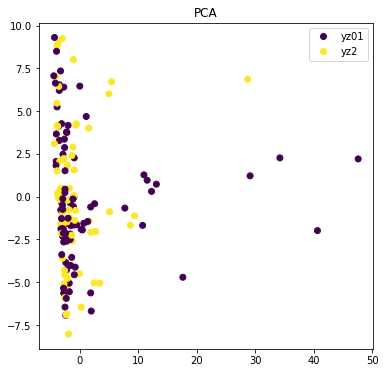

In [4]:
#https://machinelearningmastery.com/principal-component-analysis-for-visualization/
pca = PCA()
Xt = pca.fit_transform(X)
# Go through coordinates to find which patient is the outlier on the plot
#pca_coords = pd.DataFrame(Xt).iloc[:, 0:2]
#with pd.option_context('display.max_rows', 999):
#    print (pca_coords)

plt.figure(figsize=((6,6)))
plot = plt.scatter(Xt[:,0], Xt[:,1], c = y)
plt.legend(handles = plot.legend_elements()[0], labels = ['yz01', 'yz2'])
plt.title("PCA")
plt.savefig('pca final.png')
#files.download("pca.png") 

Splitting the data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, stratify = y, random_state = seed)
print(X_train.shape)
print(X_test.shape)

(130, 18)
(33, 18)


#Model selection 

Single decision tree to help visualize how the model splits the features. 

[0.42307692 0.73076923 0.46153846 0.46153846 0.53846154]
0.52 mean validation accuracy with a standard deviation of 0.11


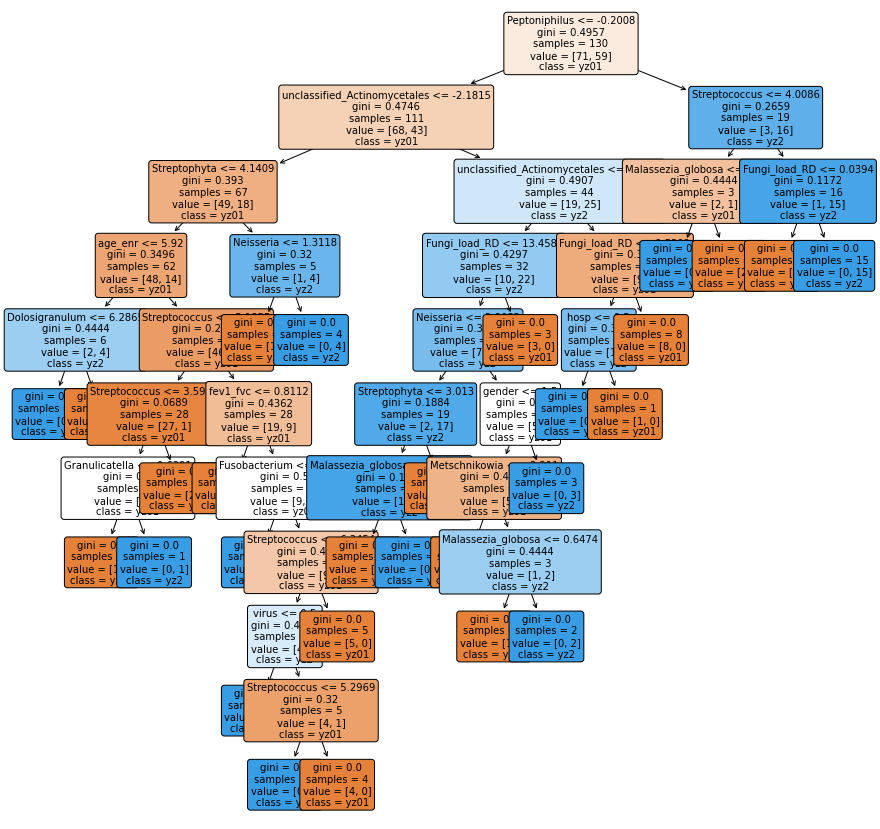

In [6]:
#https://www.analyticsvidhya.com/blog/2020/10/all-about-decision-tree-from-scratch-with-python-implementation/
dtree=DecisionTreeClassifier()
dtree.fit(X_train,y_train)
scores = cross_val_score(dtree, X_train, y_train, cv=5)
print(scores)
print("%0.2f mean validation accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

plt.figure(figsize=(15,15))  # set plot size (denoted in inches)
dec_tree = plot_tree(decision_tree=dtree, feature_names = X.columns, 
                     class_names =["yz01", "yz2"] , filled = True , precision = 4, rounded = True, fontsize=10)
plt.savefig('tree.png')
#files.download("tree.png") 

Random forest

In [7]:
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 
#https://www.analyticsvidhya.com/blog/2020/05/decision-tree-vs-random-forest-algorithm/
#https://towardsdatascience.com/what-is-out-of-bag-oob-score-in-random-forest-a7fa23d710

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 900, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']

#from the blogs above, these two parameters seem most important to tune
rfc_param_grid = {'n_estimators': n_estimators,
               'max_features': max_features}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier(random_state = seed)
# Grid search of parameters, using 5 fold cross validation, 
rfc_grid = GridSearchCV(rfc, rfc_param_grid, cv = 5) # Fit the grid search model
rfc_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=200),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'n_estimators': [1, 100, 200, 300, 400, 500, 600, 700,
                                          800, 900]})

In [8]:
print(rfc_grid.best_params_)
print("%0.2f mean validation accuracy" % rfc_grid.best_score_)

rfc_grid.best_params_['random_state'] = seed
rfc = RandomForestClassifier(**rfc_grid.best_params_)
rfc.fit(X_train, y_train)

# Evaluating on Training set
rfc_pred_train = rfc.predict(X_train)
print('Training Set Evaluation F1-Score=> %.2f' % f1_score(y_train,rfc_pred_train))

{'max_features': 'auto', 'n_estimators': 400}
0.63 mean validation accuracy
Training Set Evaluation F1-Score=> 1.00


Support Vector Machine with binary classification 

In [9]:
#One hot encoding the dataset to perform support vector classification 
OHE = OneHotEncoder()
RD_1 = RD

col = pd.DataFrame(OHE.fit_transform(RD[['gender']]).toarray())
RD_1 = RD_1.join(col.add_suffix('_gender'))
col = pd.DataFrame(OHE.fit_transform(RD[['hosp']]).toarray())
RD_1 = RD_1.join(col.add_suffix('_hosp'))
col = pd.DataFrame(OHE.fit_transform(RD[['virus']]).toarray())
RD_1 = RD_1.join(col.add_suffix('_virus'))

X = RD_1.drop(['dt_YZ', 'number.of.yellow.zones', 'gender', 'virus', 'hosp'],axis=1)
y = RD_1['dt_YZ']
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, stratify = y, random_state = seed)

In [10]:
param_grid = {'C': [1, 10, 100, 1000],
              'gamma': [0.1, 0.01, 0.001, .0001],
              'kernel': ['rbf', 'linear']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1)
 
# fitting the model for grid search
grid.fit(X_train, y_train)

print("%0.2f mean validation accuracy for svm" % grid.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
0.62 mean validation accuracy for svm


{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=100, gamma=0.001)
Training Set Evaluation F1-Score=> 0.84


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


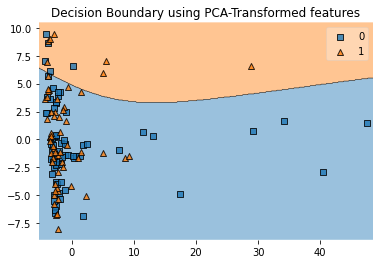

In [11]:
clf = SVC(**grid.best_params_)
print(grid.best_params_)
print(clf.fit(X_train, y_train))

y_pred = clf.predict(X_train)
print('Training Set Evaluation F1-Score=> %.2f' % f1_score(y_train, y_pred))

# Plot of SV boundaries 
pca = PCA(n_components= 2)
X_reduced = pca.fit_transform(X_train)
clf.fit(X_reduced, y_train)
plot_decision_regions(X=X_reduced, y=y_train, clf=clf, legend=1) #This is an unresolved warning message on this function's github page. I can't really prevent it from showing. 
plt.title("Decision Boundary using PCA-Transformed features")
plt.savefig('svm 1.png')

***I have selected SVM because it would give slightly higher mean validation accuracy over multiple runs that I conducted with different random seeds. I also find SVM to be more interpretable than RF.***

# Testing

Retraining the model with all the data and picking the best hyperparameters.  


In [12]:
#Adjusting the best hyperparameters.
param_grid = {'C': [10, 20, 50, 100, 250, 500], #more options for C values
              'gamma': [0.1, 0.05, 0.01]} #A small gamma of 0.01 gives the lone yz02 a bit less influence on the decision boundary.

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1)
grid.fit(X_train, y_train)
print(grid.best_params_)
clf = SVC(**grid.best_params_)
clf.fit(X_train, y_train)

print("%0.2f mean validation accuracy" % grid.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'C': 10, 'gamma': 0.01}
0.56 mean validation accuracy


Finally testing with the test data that I have not seen at all in the previous steps. 

Testing Set Evaluation F1-Score=> 0.72


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


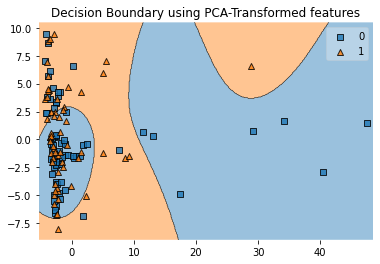

In [13]:
# Evaluating on Test set
y_pred = clf.predict(X_test)
print('Testing Set Evaluation F1-Score=> %.2f' % f1_score(y_test, y_pred))

# Plot of SV boundaries 
pca = PCA(n_components= 2)
X_reduced = pca.fit_transform(X_train)
from mlxtend.plotting import plot_decision_regions
clf.fit(X_reduced, y_train)
plot_decision_regions(X_reduced, y_train, clf=clf, legend=1)
plt.title("Decision Boundary using PCA-Transformed features")
plt.savefig('svm final.png')

              precision    recall  f1-score   support

           0       0.83      0.56      0.67        18
           1       0.62      0.87      0.72        15

    accuracy                           0.70        33
   macro avg       0.73      0.71      0.69        33
weighted avg       0.74      0.70      0.69        33



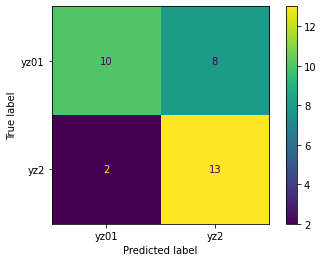

In [14]:
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ["yz01", "yz2"])
plt.savefig('confusion matrix.png')

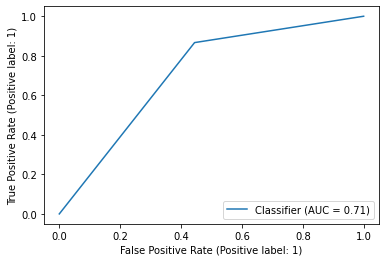

In [23]:
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.savefig('roc.png')